In [1]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Get the data

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("datasets/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get(
            "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

datasets\pizza_steak_sushi directory exists.


# 2. Become one with data (data preparation)

In [3]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(
        f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)

There are 2 directories and 0 images in 'datasets\pizza_steak_sushi'.
There are 3 directories and 0 images in 'datasets\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'datasets\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'datasets\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'datasets\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'datasets\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'datasets\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'datasets\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'datasets\pizza_steak_sushi\train\sushi'.


In [4]:
# setup train and testing paths
train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir, test_dir

(WindowsPath('datasets/pizza_steak_sushi/train'),
 WindowsPath('datasets/pizza_steak_sushi/test'))

### 2.1 visualize an image

random image path: datasets\pizza_steak_sushi\test\sushi\2394442.jpg
image class: sushi
image height: 408
image width: 512


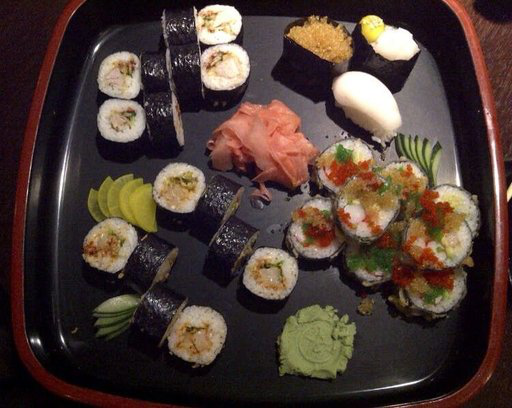

In [5]:
from PIL import Image
import random

# set seed
random.seed(42)

# 1. get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2.  get random image path
random_image_path = random.choice(image_path_list)

# 3. get image class from pathname
image_class = random_image_path.parent.stem

# 4. open image
img = Image.open(random_image_path)

# 5. print metadata
print(f"random image path: {random_image_path}")
print(f"image class: {image_class}")
print(f"image height: {img.height}")
print(f"image width: {img.width}")
img

(-0.5, 511.5, 407.5, -0.5)

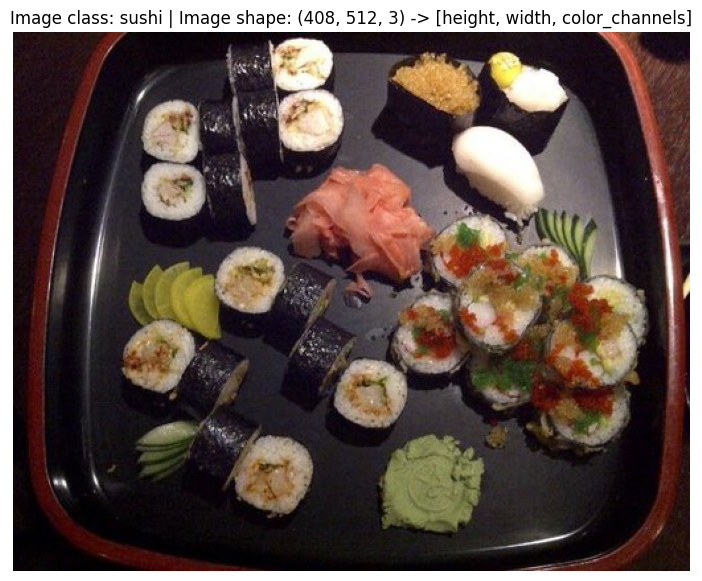

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(
    f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

# 3. Transforming data

In [7]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [8]:
# write tranform for image
data_transform = transforms.Compose([
  # resize the images 
  transforms.Resize(size=(64, 64)),
  # flip image randomly on the horizontal
  transforms.RandomHorizontalFlip(p=0.5), # p=probability of flip 0.5 = 50% chance
  # turn image into tensor
  transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

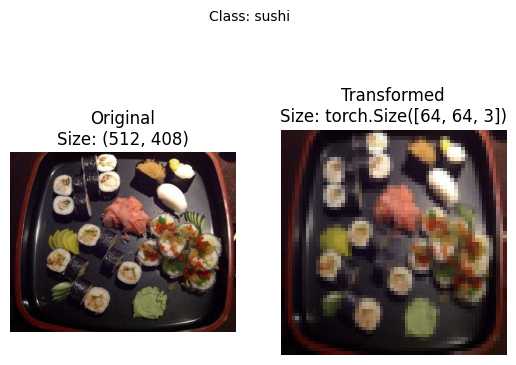

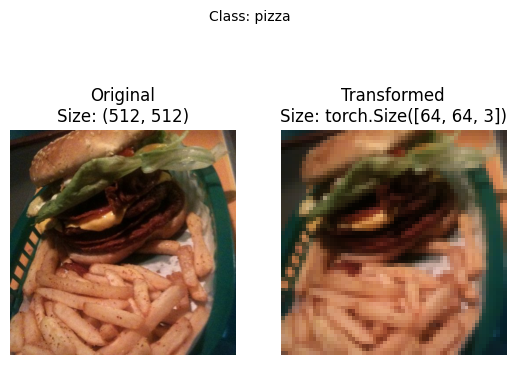

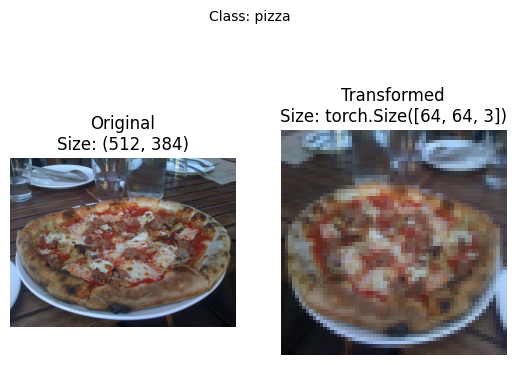

In [9]:
# visualize transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """Plots a series of random images from image_paths.

  Will open n image paths from image_paths, transform them
  with transform and plot them side by side.

  Args:
      image_paths (list): List of target image paths. 
      transform (PyTorch Transforms): Transforms to apply to images.
      n (int, optional): Number of images to plot. Defaults to 3.
      seed (int, optional): Random seed for the random generator. Defaults to 42.
  """
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(fp=image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      # Note: permute() will change shape of image to suit matplotlib
      # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=10)

plot_transformed_images(
  image_paths= image_path_list,
  transform=data_transform,
  n=3
)


# 4. Option 1: loading image data with ImageFolder

In [10]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, # target folder og images
                                  transform=data_transform,
                                  target_transform=None)  # transforms to perform on labels (if necessary
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"train data:\n{train_data}\ntest data:\n{test_data}")

train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: datasets\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: datasets\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [11]:
# get classname as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [12]:
# get classname as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [13]:
# check the length
len(train_data), len(test_data)

(225, 75)

In [14]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

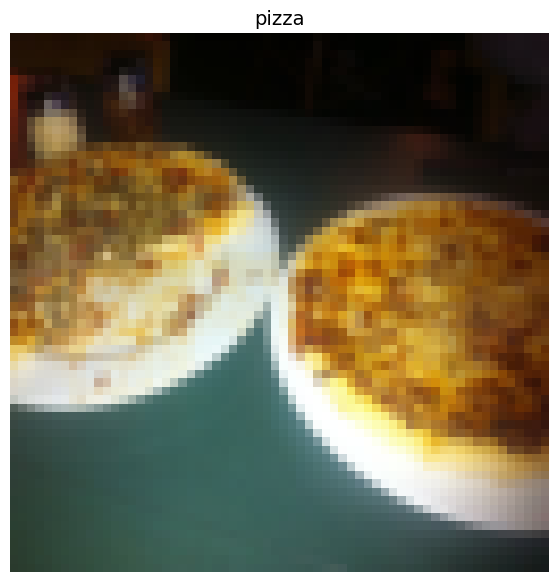

In [15]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(
    f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 loaded image into DataLoader

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many sample perbatch?
                              num_workers=1, # how many subprocess to use for load data loading?,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x211687984d0>,
 <torch.utils.data.dataloader.DataLoader at 0x211687bab50>)

In [17]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(
    f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# 5. Loading image with a custom Dataset

In [18]:
import pathlib
import torch
import os

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

### 5.1 creating helper func to get class names

In [19]:
# setup path target dir
target_directory = train_dir
print(f"Target directory: {target_directory}")

# get class names from target dir
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path/"train"))])
print(f"classname: {class_names_found}")

Target directory: datasets\pizza_steak_sushi\train
classname: ['pizza', 'steak', 'sushi']


In [20]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory.
  
  Assumes target directory is in standard image classification format.

  Args:
      directory (str): target directory to load classnames from.

  Returns:
      Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
  
  Example:
      find_classes("food_images/train")
      >>> (["class_1", "class_2"], {"class_1": 0, ...})
  """
  # 1. get the classname
  classes = sorted( entry.name for entry in list(os.scandir(directory)) if entry.is_dir() )

  # 2. raise error if classname not founded
  if not classes:
    raise FileNotFoundError("Could't find any classes in dir: ", directory)
  
  # 3. create dict class name
  classes_idx = {cls_name: i for i, cls_name in enumerate(classes)}

  return classes, classes_idx 

find_classes(directory=train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 create a custom Dataset to replicate ImageFolder

In [21]:
from torch.utils.data import Dataset

# 1. subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  
  # 2. initialize with target_dir and transform (optional) parameter
  def __init__(self, target_dir:str, transform=None) -> None:
    super().__init__()

    # 3. create class attributes
    # get all image path
    self.paths = list(pathlib.Path(target_dir).glob(pattern="*/*.jpg"))
    # setup transform
    self.transform = transform
    # create classes and class_idx attributes
    self.classes, self.class_to_idx = find_classes(target_dir)

  # 4. make func to load images
  def load_image(self, index:int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)
  
  # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
  def __len__(self) -> int:
    "Returns the total number of sample"
    return len(self.paths)
  
  # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
  def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)"
    img = self.load_image(index)
    # expects path in data_folder/class_name/image.jpeg
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data label (X, y)
    else:
      return img, class_idx

In [22]:
# CREATE SOME TRANSFORM FOR AUGMRNTED
# augment train data
train_transform = transforms.Compose([
  transforms.Resize((64,64)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor()
])

# augment test data
test_transform = transforms.Compose([
  transforms.Resize((64,64)),
  transforms.ToTensor()
])

In [23]:
train_data_custom = ImageFolderCustom(target_dir=train_dir,
                                      transform=train_transform)
test_data_custom = ImageFolderCustom(target_dir=test_dir,
                                     transform=test_transform)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x21168784cd0>,
 <__main__.ImageFolderCustom at 0x2116880ed10>)

In [24]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [25]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [26]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data))
      & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### 5.3 create fucn to display images

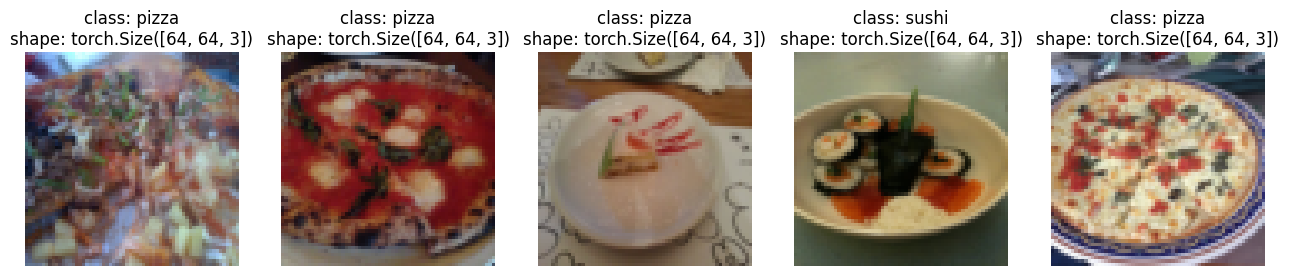

In [27]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

display_random_images(dataset=train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

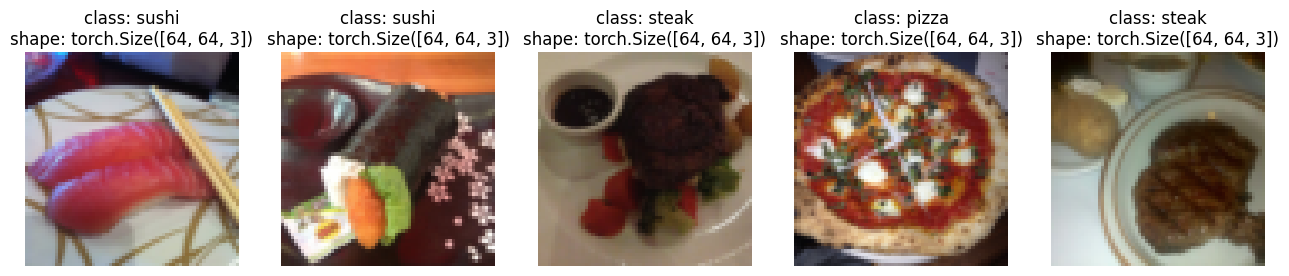

In [28]:
# try with custom dataset object
display_random_images(dataset=train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

### 5.4 turn custom loaded image into DataLoader

In [29]:
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=1,
                                     num_workers=0,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=1,
                                     num_workers=0,
                                     shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x21168360050>,
 <torch.utils.data.dataloader.DataLoader at 0x21168552390>)

In [30]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(
    f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# 6. other forms transform 

In [31]:
# CREATE SOME TRANSFORM FOR AUGMRNTED with TRIVIAL AUGMENT
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# augment test data
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Note: You usually don't perform data augmentation on the test set. The idea of data augmentation is to to artificially increase the diversity of the training set to better predict on the testing set.

However, you do need to make sure your test set images are transformed to tensors. We size the test images to the same size as our training images too, however, inference can be done on different size images if necessary (though this may alter performance).

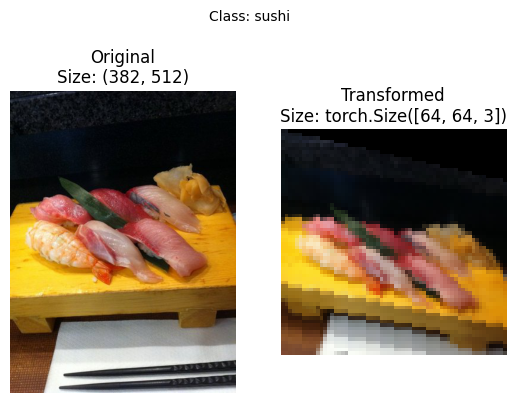

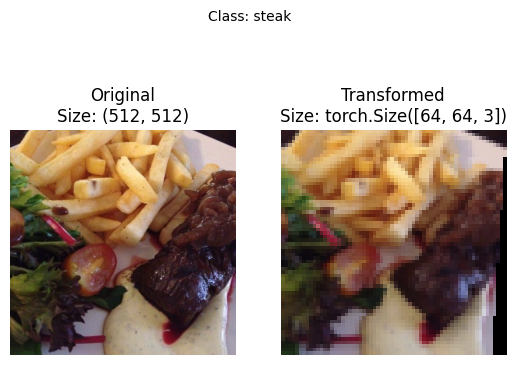

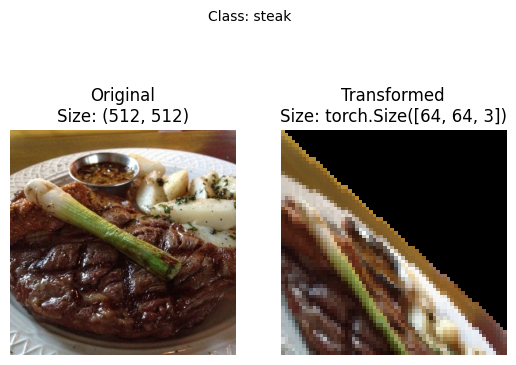

In [32]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

# 7. Mode 0: tiny VGG without augmentation

In [33]:
# create simple transform 
simple_transform = transforms.Compose([
  transforms.Resize((64,64)),
  transforms.ToTensor()
])

In [34]:
# 1. load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. turn data into data loader
from torch.utils.data import DataLoader
import os

# setup batchsize and numworkers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"batchsize: {BATCH_SIZE}, numworkers: {NUM_WORKERS}")

# create dataloaders
train_dataloader_simple = DataLoader(
  dataset=train_data_simple,
  batch_size=BATCH_SIZE,
  shuffle=True,
  num_workers=NUM_WORKERS
)
test_dataloader_simple = DataLoader(
    dataset=train_data_simple,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)
train_data_simple, test_data_simple

batchsize: 32, numworkers: 8


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: datasets\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: datasets\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

### 7.2 create tinyvgg model

In [35]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int)->None:
    super().__init__()
    self.block_conv_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,
                   stride=2)
    )
    self.block_conv_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,
                   stride=2)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*16*16,
                out_features=output_shape)
    )

  def forward(self, x):
    x = self.block_conv_1(x)
    x = self.block_conv_2(x)
    x = self.classifier(x)
    return x
  
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (block_conv_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_conv_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 try forward pass on single image (to test model)

In [36]:
# 1. get a batch of images and labels from dataloader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. get a single image from batch and unsqueze, so its shape fits on model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"single image shape: {img_single.shape}")

# 3. perform forward pass on a single image
model_0.eval()
with torch.inference_mode():
  logit = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{logit}\n")
print(f"Output prediction probabilities:\n{torch.softmax(logit, dim=1)}\n")
print(
    f"Output prediction label:\n{torch.argmax(torch.softmax(logit, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

single image shape: torch.Size([1, 3, 64, 64])
Output logits:
tensor([[ 0.0160,  0.0418, -0.0343]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3359, 0.3447, 0.3194]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
1


### 7.4 use torch info tp get idea of the shape going through model

In [37]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass thorught an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-8                    [1, 10, 16, 16]           --
├─Sequential: 1-3                        [1, 3]                    --
│    └─Flatten: 2-9                      [1, 2560]                 --
│    └─Linea

### 7.5 create train/test loop

In [38]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [39]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() /
                         len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 creataing train()

In [40]:
from tqdm.auto import tqdm

# 1. take in various parameter required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs:int=5):
  # 2. create empty result dict
  results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
  }

  # 3. loo[ throught train and test steps for a number of samples
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # 4. printout what happening
    print(
      f"Epoch: {epoch+1} | "
      f"train_loss: {train_loss:.4f}"
      f"train_acc: {train_acc:.4f}%"
      f"test_loss: {test_loss:.4f}"
      f"test_acc: {test_acc:.4f}%"
    )

    # 5. update results dict
    results["train_loss"].append(train_loss) 
    results["train_acc"].append(train_acc) 
    results["test_loss"].append(test_loss) 
    results["test_acc"].append(test_acc) 

  # 6. return the filled result at the end the epoch
  return results

d:\Software\ananconda3\envs\ludesc\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 7.7 train and evaluate

In [41]:
# Set random seeds
from timeit import default_timer as timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,  # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:35<02:22, 35.71s/it]

Epoch: 1 | train_loss: 1.0982train_acc: 0.4141%test_loss: 1.1093test_acc: 0.3047%


 40%|████      | 2/5 [01:29<02:18, 46.30s/it]

Epoch: 2 | train_loss: 1.1120train_acc: 0.3047%test_loss: 1.1051test_acc: 0.3047%


 60%|██████    | 3/5 [02:02<01:20, 40.27s/it]

Epoch: 3 | train_loss: 1.0892train_acc: 0.4258%test_loss: 1.1113test_acc: 0.3047%


 80%|████████  | 4/5 [02:41<00:39, 39.70s/it]

Epoch: 4 | train_loss: 1.0982train_acc: 0.3047%test_loss: 1.1189test_acc: 0.3047%


100%|██████████| 5/5 [03:04<00:00, 36.82s/it]

Epoch: 5 | train_loss: 1.1234train_acc: 0.3242%test_loss: 1.1132test_acc: 0.3516%
Total training time: 184.149 seconds


### 7.8 plot the loss curve

In [42]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

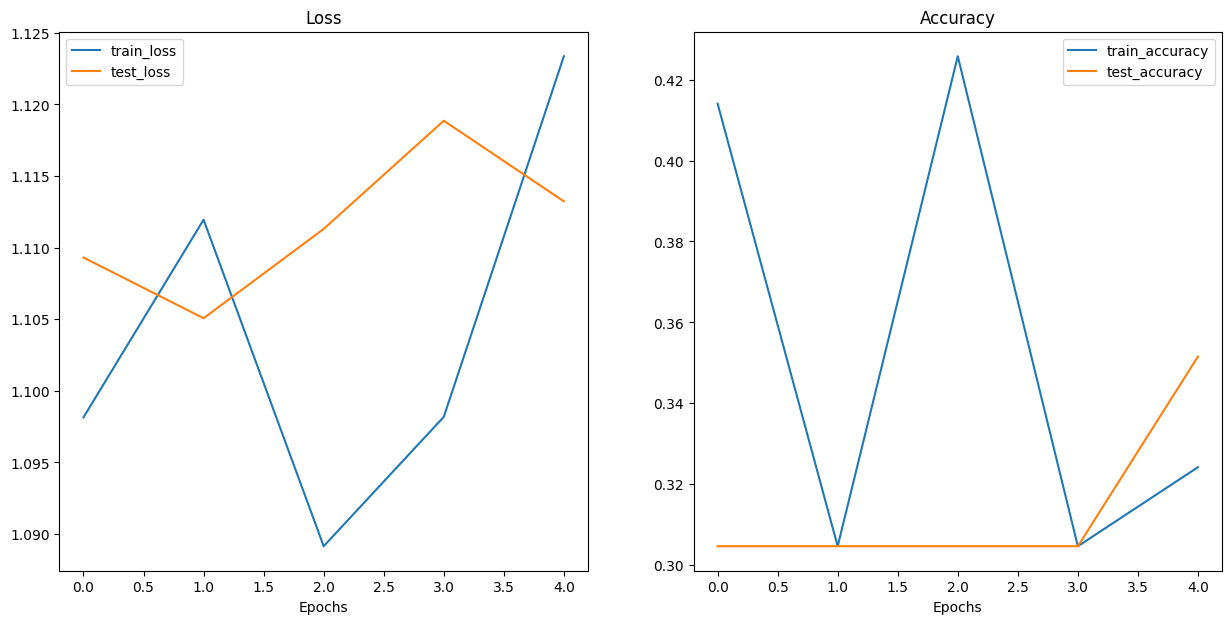

In [43]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(model_0_results)

# 8. what should an ideal loss curve look like?
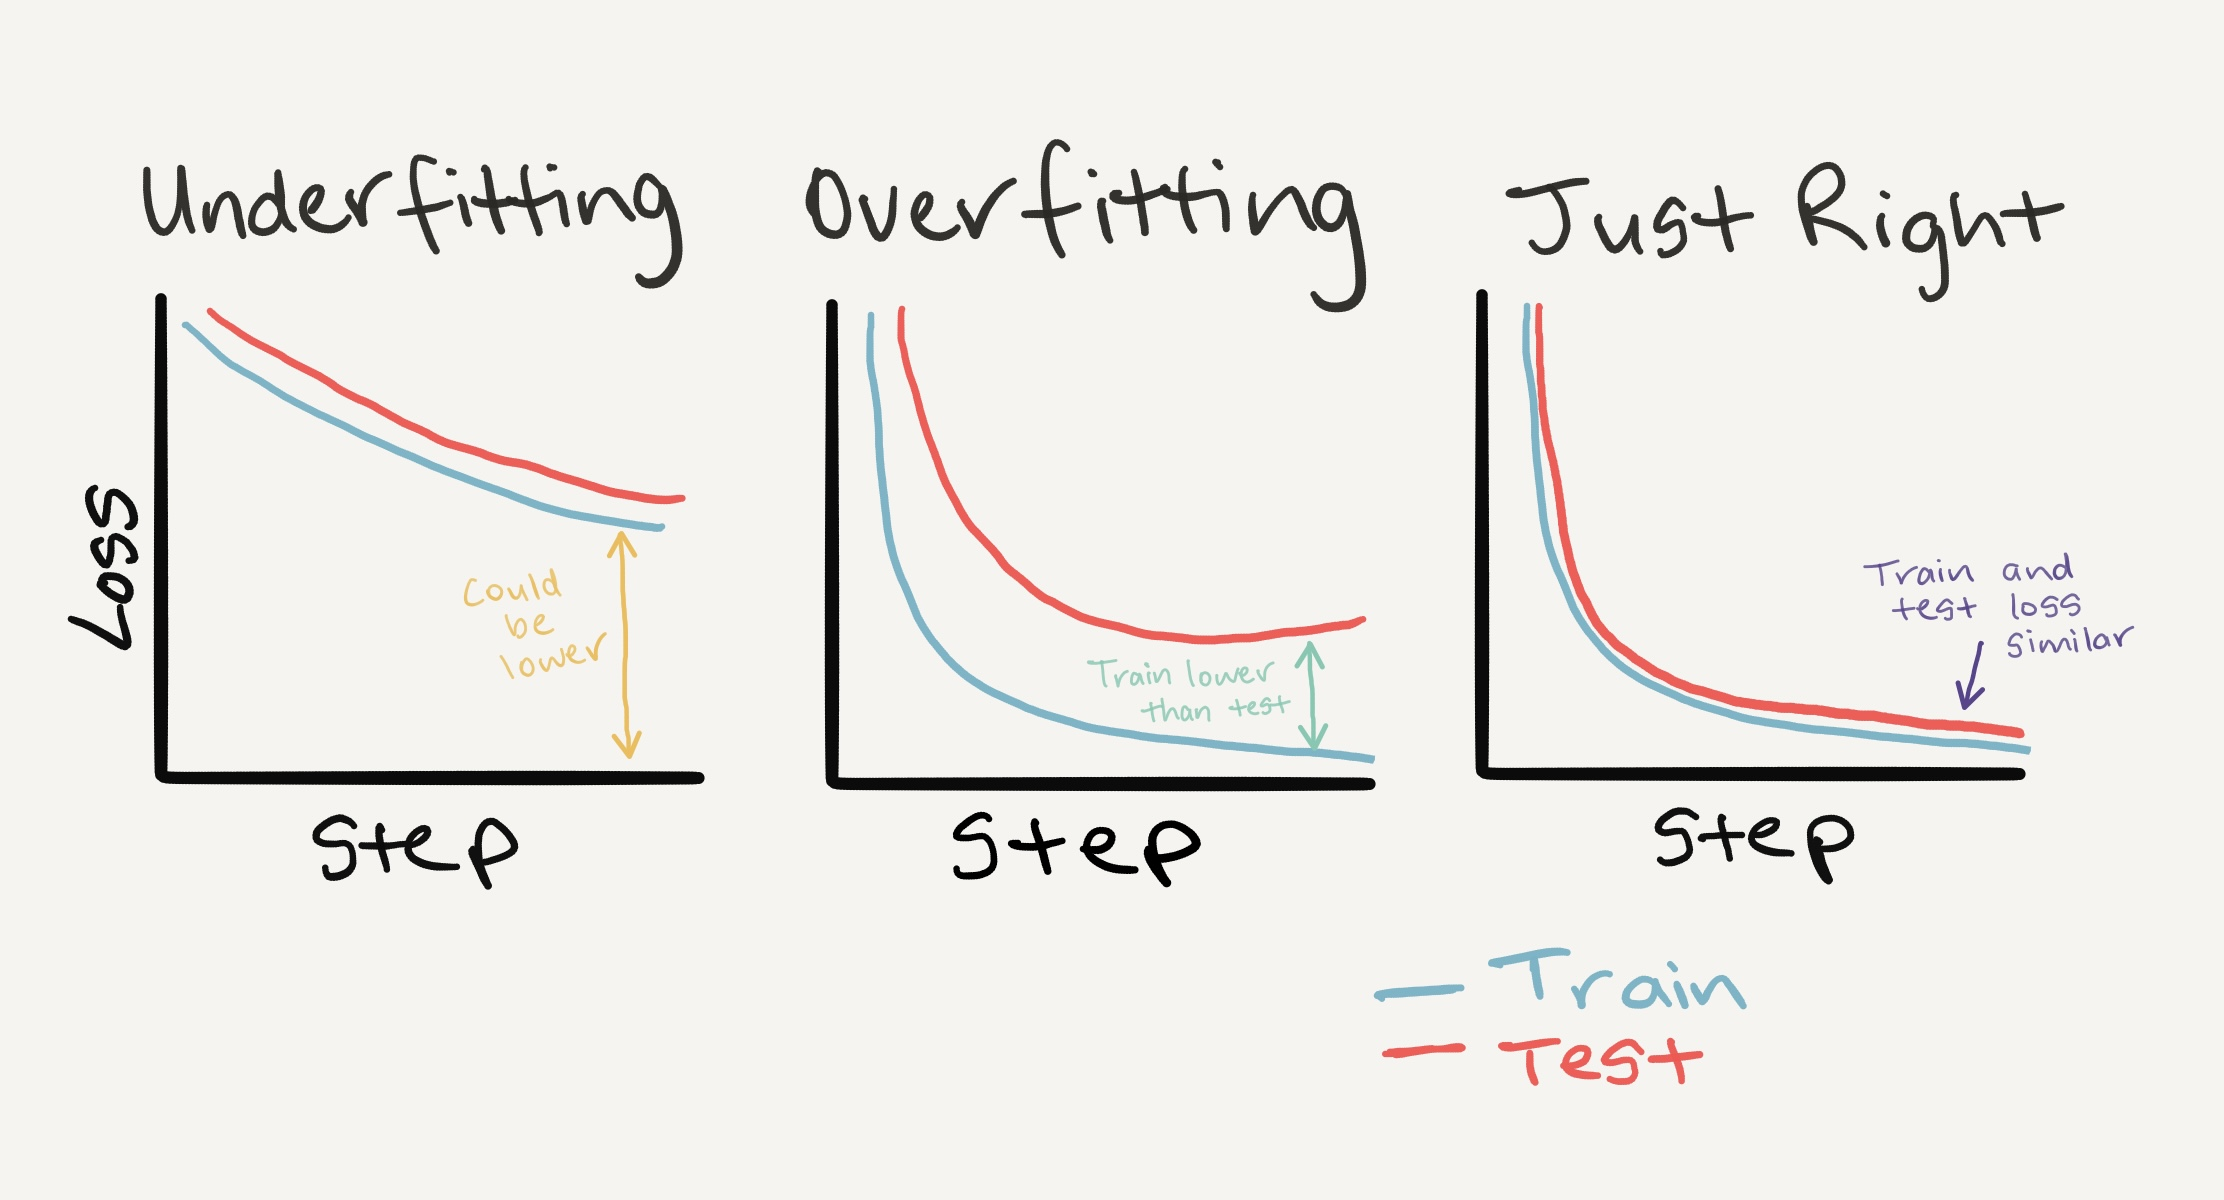

# 9. Model 1: tiny vgg with data augmentation


### 9.1 create transform with data augmentation

In [44]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### 9.2 create train and test Dataset and DataLoader

In [45]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(
    train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: datasets\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: datasets\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [46]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x211689ad190>,
 <torch.utils.data.dataloader.DataLoader at 0x211687bab50>)

### 9.3 contruct and train model 1

In [47]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (block_conv_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_conv_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [48]:
# Set random seeds
from timeit import default_timer as timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:42<02:51, 43.00s/it]

Epoch: 1 | train_loss: 1.1064train_acc: 0.2500%test_loss: 1.1013test_acc: 0.2604%


 40%|████      | 2/5 [01:23<02:04, 41.40s/it]

Epoch: 2 | train_loss: 1.0805train_acc: 0.4258%test_loss: 1.1283test_acc: 0.2604%


 60%|██████    | 3/5 [02:08<01:26, 43.24s/it]

Epoch: 3 | train_loss: 1.0784train_acc: 0.4258%test_loss: 1.1579test_acc: 0.2604%


 80%|████████  | 4/5 [02:47<00:41, 41.48s/it]

Epoch: 4 | train_loss: 1.1265train_acc: 0.3047%test_loss: 1.1623test_acc: 0.2604%


100%|██████████| 5/5 [03:12<00:00, 38.57s/it]

Epoch: 5 | train_loss: 1.0845train_acc: 0.4258%test_loss: 1.1532test_acc: 0.2604%
Total training time: 192.855 seconds


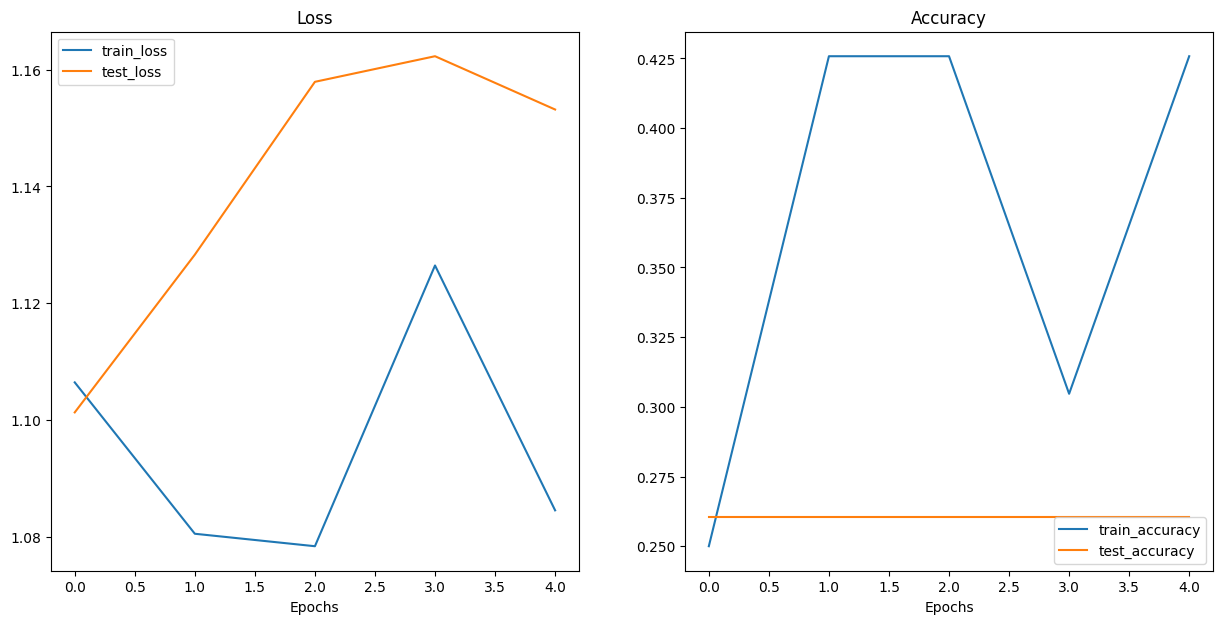

In [49]:
plot_loss_curves(model_1_results)

# 10. compare model results

In [50]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df, model_1_df

(   train_loss  train_acc  test_loss  test_acc
 0    1.098153   0.414062   1.109311  0.304688
 1    1.111951   0.304688   1.105073  0.304688
 2    1.089151   0.425781   1.111309  0.304688
 3    1.098182   0.304688   1.118864  0.304688
 4    1.123370   0.324219   1.113238  0.351562,
    train_loss  train_acc  test_loss  test_acc
 0    1.106444   0.250000   1.101300  0.260417
 1    1.080512   0.425781   1.128321  0.260417
 2    1.078377   0.425781   1.157927  0.260417
 3    1.126468   0.304688   1.162312  0.260417
 4    1.084522   0.425781   1.153183  0.260417)

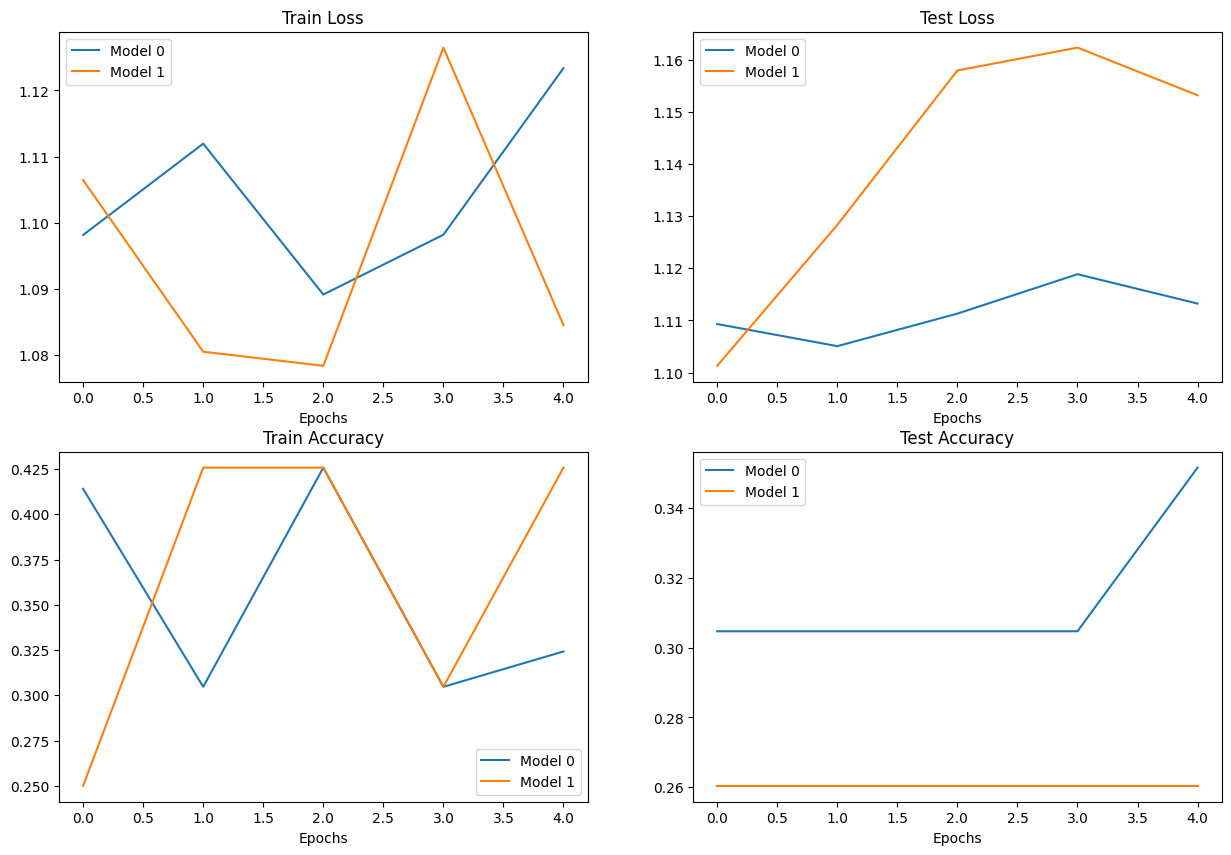

In [51]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

# 11. make prediction on a custom images

In [53]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get(
            "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

### 11.1 load image

In [54]:
import torchvision

# read custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

In [55]:
# Try to make a prediction on image in uint8 format (this will error)
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

So before we use our custom image with our model, we'll need to convert it to the same format as the data our model is trained on.

In [56]:
# load image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# divide pixel value by 255
custom_image = custom_image/255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

### 11.2 prediction with trained mode

(-0.5, 3023.5, 4031.5, -0.5)

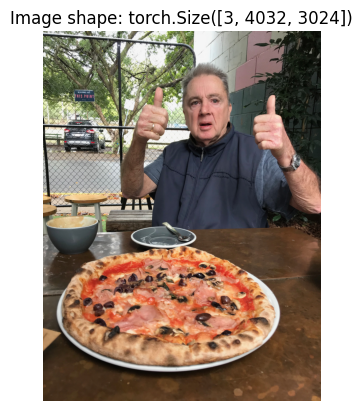

In [57]:
# Plot custom image
# need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.imshow(custom_image.permute(1, 2, 0))
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False)

In [58]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


d:\Software\ananconda3\envs\ludesc\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [59]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

In [60]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

dimensi yg diinginkan model adalah `NCHW` yaitu N adalah BatchSize

In [63]:
model_1.eval()
with torch.inference_mode():
  # add extra dimension
  custom_image_transformed_batchsize = custom_image_transformed.unsqueeze(dim=0)

  # Print out different shapes
  print(f"Custom image transformed shape: {custom_image_transformed.shape}")
  print(f"Unsqueezed custom image shape: {custom_image_transformed_batchsize.shape}")
  
  # Make a prediction on image with an extra dimension
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [64]:
custom_image_pred

tensor([[ 0.1443, -0.0326, -0.2087]], device='cuda:0')

In [65]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1443, -0.0326, -0.2087]], device='cuda:0')
Prediction probabilities: tensor([[0.3936, 0.3298, 0.2766]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [68]:
# find predition label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()]
custom_image_pred_class

'pizza'

### 11.3 putting custom image prediciton together

tensor([[0.3936, 0.3298, 0.2766]], device='cuda:0')


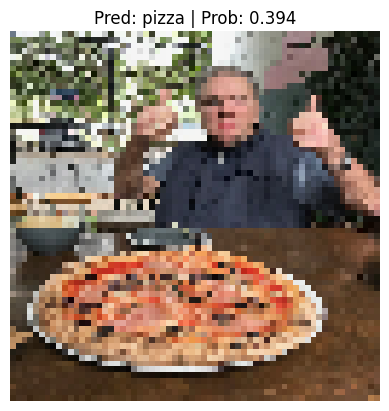

In [77]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str]=None,
                        transform=None,
                        device: torch.device=device):
  # 1. load image and convert into tensor value
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # 2. divide pixel to 255 to get range between 0 - 1
  target_image = target_image/255.

  # 3. transform is necessary
  if transform:
    target_image = transform(target_image)

  # 4. make model to target device
  model.to(device)

  # 5. turn on model evaluation mode
  model.eval()
  with torch.inference_mode():
    # add extra dimension on target image
    target_image = target_image.unsqueeze(dim=0)

    # make prediciton
    target_image_pred = model(target_image.to(device))

  # 6. convert logit pred to probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)  
  print(target_image_pred_probs)
  
  # 7. Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
  
  # 8. Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
  if class_names:
      title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else: 
      title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False);

# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)